In [ ]:
!nvidia-smi

Thu Oct 27 15:41:30 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torch

from torchvision import transforms, datasets
from torch.utils import data as torch_data
from torch.utils.data import Dataset
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
from torch import flatten

import math
import logging

import os
import random
from tqdm import tqdm
import cv2
import numpy as np

import matplotlib.pyplot as plt

from google.colab import drive

In [ ]:
#drive.mount("my-drive")
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def get_training_data(args):
    data = []
    for label in args.labels:
        path = os.path.join(args.data_dir, label)
        class_num = args.labels.index(label)
        for img in tqdm(os.listdir(path)):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (args.img_size, args.img_size))/255. # Reshaping images to preferred size
                data.append([resized_arr.astype(np.float32), class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [ ]:
class Dataset_V2(torch_data.Dataset):
  def __init__(self, data, transforms):
    self.transform = transforms
    self.x = data[:,0]
    self.y = data[:,1]

    self.labels, self.counts = np.unique(self.y, return_counts= True)

  def __len__(self):
    return len(self.x)

  def __getitem__(self, idx):
    return self.transform(self.x[idx]) , self.y[idx]

In [ ]:
class ResNet50(nn.Module):
  def __init__(self, pretrain=True):
    super(ResNet50, self).__init__()

    self.conv1 = nn.Conv2d(1, 48, kernel_size=7, stride=2, padding=1)
    self.conv2 = nn.Conv2d(48, 64, kernel_size=5, stride=2, padding=1)
    self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
    self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
    self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)

    self.bn1 = nn.BatchNorm2d(48)
    self.bn2 = nn.BatchNorm2d(64)
    self.bn3 = nn.BatchNorm2d(64)
    self.bn4 = nn.BatchNorm2d(128)
    self.bn5 = nn.BatchNorm2d(256)

    self.pool = nn.MaxPool2d(2,2)
    self.dropout = nn.Dropout(p=0.1)

    self.fc1 = nn.Linear(3*3*256, 128)
    self.fc2 = nn.Linear(128, 32)
    self.fc3 = nn.Linear(32, 4)

  def forward(self, x):

    x = F.relu(self.conv1(x))
    x = self.bn1(x)

    x = F.relu(self.conv2(x))
    x = self.bn2(x)

    x = F.relu(self.conv3(x))
    x = self.bn3(x)
    x = self.dropout(x) #do1
    x = self.pool(x)

    x = F.relu(self.conv4(x))
    x = self.bn4(x)
    x = self.dropout(x) #do2
    x = self.pool(x)

    x = F.relu(self.conv5(x))
    x = self.bn5(x)
    x = self.dropout(x) #do3
    x = self.pool(x)

    x = flatten(x, start_dim=1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)

    return x

In [ ]:
class Client():
  def __init__(self, Id, args, data=None):
    self.Id = Id
    self.data = data
    self.dataLoader = None

    self.batchSize = args.batch_size
    self.lr = args.lr
    self.device = args.device

    self.model = ResNet50().to(self.device)

    if(data is not None):
      self.dataset = self.assignDataset(dataset)

    self.augmentedData = None
    self.augmentedDataset = None
    self.augmentedDataLoader = None

  def assignData(self, data, dataType):
    if(dataType == "Original"):
      self.data = data
      self.dataset = Dataset_V2(self.data, transforms.ToTensor())
      self.dataLoader = torch.utils.data.DataLoader(self.dataset, batch_size=self.batchSize)

    elif(dataType == "Augmented"):
      self.augmentedData = data
      self.augmentedDataset = Dataset_V2(self.augmentedData, transforms.ToTensor())
      self.augmentedDataLoader = torch.utils.data.DataLoader(self.augmentedDataset, batch_size=self.batchSize)

  def localTrain(self, dataType, globalModel, localEpochs, criterion):
    device = self.device

    self.model.load_state_dict(globalModel.state_dict())
    self.model.train()

    optimizer = torch.optim.Adadelta(self.model.parameters(), lr = self.lr)

    sampleCount = len(self.dataset) if dataType == "Original" else len(self.augmentedDataset)
    loader = self.dataLoader if dataType == "Original" else self.augmentedDataLoader
    update = {}
    correct = 0

    for epoch in range(localEpochs):
      epochCorrect = 0
      epochLoss = 0.0

      for batchIdx, (x, y) in enumerate(loader):
        x, y = x.to(self.device), y.to(self.device)
        output = self.model(x)
        batchLoss = criterion(output, y)
        optimizer.zero_grad()
        batchLoss.backward()
        optimizer.step()
        pred = output.argmax(dim=1, keepdim=True)
        epochCorrect += pred.eq(y.view_as(pred)).sum().item()
        epochLoss += batchLoss.item()

      correct += epochCorrect

      print('LOCAL_EPOCH: {}  Client: {} \tLoss: {:.6f} Accuracy: {}/{} ({:.3f}%)'.format(
              epoch, self.Id, epochLoss / (len(loader)), epochCorrect, sampleCount, (100. * epochCorrect) / sampleCount))

    update["update"] = self.model.state_dict()
    update["sampleCount"] = sampleCount * localEpochs
    return update

In [ ]:
class FLSimulator():
  def __init__(self, train_set, args, distribution = "IID"):
    self.num_clients = args.num_clients
    self.clients = self.create_client_devices(self.num_clients, args)
    self.train_set = train_set
    self.s = splitter(self.train_set)
    self.args = args

    if distribution == "IID":
      self.s.IID(self.clients)
    elif distribution =="Non_IID":
      self.s.Non_IID(self.clients)
    elif distribution == "quantity_skew":
      self.s.quantitySkew(self.clients)


  def create_client_devices(self, num_clients, args):
    clients = {}
    for i in range(num_clients):
      clients["VW_" + str(i)] = Client("VW_" + str(i), args)

    return clients

  def print_client_distributions(self):
    for client in self.clients:
      print(self.clients[client].dataset.counts)

  def plotDataDistribution(self):
    maxLabelCount = 0
    for client in self.clients:
      if len(self.clients[client].dataset.labels) >= maxLabelCount:
        maxLabelCount = len(self.clients[client].dataset.labels)

    values = np.ones((len(self.clients), maxLabelCount))
    for idx, client in enumerate(self.clients):
      values[idx] = self.clients[client].dataset.counts

    x = ["C_" + str(i) for i in range(1,len(self.clients)+1)]

    plt.figure(figsize=(12, 6), dpi=100)

    plt.bar(x, values[:,0], width=0.3)
    plt.bar(x, values[:,1], 0.3, bottom = values[:,0])
    plt.bar(x, values[:,2], 0.3, bottom = values[:,0] + values[:,1])
    #plt.bar(x, values[:,3], 0.3, bottom = values[:,0] + values[:,1] + values[:,2])

    plt.legend(self.args.labels)

    plt.xlabel("Client ID")
    plt.ylabel("# of Samples")

    plt.show()

In [ ]:
class server():
  def __init__(self, test_set, clients, args):
    self.globalModel = ResNet50().to(device)
    self.clients = clients
    self.num_clients_round = args.num_clients_round
    self.test_set = test_set
    self.test_loader = torch_data.DataLoader(Dataset_V2(self.test_set, transforms.ToTensor()), shuffle=False)
    self.b = balancer()
    self.aggregator = FederatedAggregation()
    self.criterion = nn.CrossEntropyLoss()
    self.args = args

  def federated_train(self, num_comm_round):

    test_accuracies = []
    test_lossess = []

    for round in range(num_comm_round):
      print("communication round: " + str(round))
      selected_clients = self.random_select_clients(self.clients, self.args.num_clients_round)
      self.b.balanceClientsDistribution(self.clients, selected_clients)

      roundUpdates = []
      for client in selected_clients:
        roundUpdates.append(self.clients[client].localTrain("Augmented", self.globalModel, args.num_local_epochs, self.criterion))
      self.aggregator.aggregate(self.globalModel, roundUpdates)
      test_loss, test_accuracy = self.test()
      test_accuracies.append(test_accuracy)
      test_lossess.append(test_lossess)

    return test_accuracies,  test_lossess

  def random_select_clients(self, clients, number):
    return random.sample(list(clients), number)

  def test(self):
    self.globalModel.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for x, y in self.test_loader:
            x, y = x.to(device), y.to(device)
            output = self.globalModel(x)
            test_loss += self.criterion(output, y).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(y.view_as(pred)).sum().item()

    test_loss /= len(self.test_loader.dataset)
    test_accuracy = 100. * correct / (len(self.test_loader)* self.test_loader.batch_size)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(self.test_loader) * self.test_loader.batch_size, test_accuracy))

    return test_loss, test_accuracy

In [ ]:
class FederatedAggregation():
  def __init__(self, args=None):
    self.args = args

  def aggregate(self, globalModel, clientUpdates):
    aggregatedUpdates = self.FedAvg(clientUpdates)
    globalModel.load_state_dict(aggregatedUpdates)

  def FedAvg(self, updates):
    layers = updates[0]["update"].keys()
    aggregatedUpdates = dict.fromkeys(layers)

    totalSample = 0
    for update in updates:
      for layer in layers:
        if(aggregatedUpdates[layer] is None):
          aggregatedUpdates[layer] = update["sampleCount"] * update["update"][layer]
        else:
          aggregatedUpdates[layer] += update["sampleCount"] * update["update"][layer]
      totalSample += update["sampleCount"]

    for layer in layers:
      try:
        aggregatedUpdates[layer] /= totalSample
      except:
        aggregatedUpdates[layer] = torch.tensor(aggregatedUpdates[layer] / totalSample)

    return aggregatedUpdates

In [ ]:
class splitter():
  def __init__(self, dataset, dirichletParams = 1):
    self.dataset = dataset
    self.dirichletParams = dirichletParams

  def IID(self, clients):
    train_set = self.dataset
    len_train_set = len(train_set)
    len_client_set = int(len_train_set / len(clients))

    for i, client in enumerate(clients):
      dataset = train_set[i*len_client_set:(i+1)*len_client_set]
      clients[client].assignData(dataset, "Original")

    return clients

  def quantitySkew(self, clients):
    train_set = self.dataset
    len_train_set = len(train_set)
    num_clients = len(clients)

    intervals = np.floor(np.random.dirichlet(num_clients*(self.dirichletParams,), 1)*len_train_set).astype(int).squeeze()
    count = 0
    for i, client in enumerate(clients):
      dataset = train_set[count : count + intervals[i]]
      clients[client].assignData(dataset, "Original")
      count += intervals[i]

    return clients

  def Non_IID(self, clients):
    train_set = self.dataset
    len_train_set = len(train_set)
    num_clients = len(clients)

    intervals = {}
    labels, counts = np.unique(train_set[:,1], return_counts= True)

    sample_counts = {}

    for label, count in zip(labels, counts):
      intervals[label] = (np.random.dirichlet(num_clients*(self.dirichletParams,),1)*count).astype(int).squeeze()
      intervals[label] = np.where(intervals[label] == 0, 1, intervals[label])
      sample_counts[label] = 0

    for i, client in enumerate(clients):
      dataset = np.empty_like(train_set[0:0])
      for label in labels:
        dataset = np.concatenate((dataset, train_set[train_set[:,1] == label][sample_counts[label]:sample_counts[label]+intervals[label][i]]), axis=0)
        sample_counts[label] += intervals[label][i]

      np.random.shuffle(dataset)
      clients[client].assignData(dataset, "Original")

    return clients

In [ ]:
class AddGaussianNoise(object):
  def __init__(self, mean=0., std=0.015):
    self.std = std
    self.mean = mean

  def __call__(self, tensor):
    return (tensor + torch.randn(tensor.size())*self.std + self.mean).squeeze()

  def __repr__(self):
    return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [ ]:
class augTransforms():
  def __init__(self):
    self.HFlip = transforms.Compose([transforms.ToTensor(), transforms.ToPILImage(), transforms.RandomHorizontalFlip(p=1),transforms.ToTensor()])
    self.VFlip = transforms.Compose([transforms.ToTensor(), transforms.ToPILImage(), transforms.RandomVerticalFlip(p=1),transforms.ToTensor()])
    self.RRotation = transforms.Compose([transforms.ToTensor(), transforms.ToPILImage(), transforms.RandomRotation(degrees = (-30,30)),transforms.ToTensor()])
    self.RCrop = transforms.Compose([transforms.ToTensor(), transforms.ToPILImage(), transforms.RandomCrop((128,128), padding=28),transforms.ToTensor()])
    self.CJitter = transforms.Compose([transforms.ToTensor(), transforms.ToPILImage(), transforms.ColorJitter(brightness=.3, contrast=.3, saturation=.3,hue=.3),transforms.ToTensor()])
    self.RInvert = transforms.Compose([transforms.ToTensor(), transforms.ToPILImage(), transforms.RandomInvert(p=1),transforms.ToTensor()])
    self.RAdjustSharpness = transforms.Compose([transforms.ToTensor(), transforms.ToPILImage(), transforms.RandomAdjustSharpness(sharpness_factor=3, p=1),transforms.ToTensor()])
    self.RAutoContrast = transforms.Compose([transforms.ToTensor(), transforms.ToPILImage(), transforms.RandomAutocontrast(p=1), transforms.ToTensor()])
    self.REqualize = transforms.Compose([transforms.ToTensor(), transforms.ToPILImage(), transforms.RandomEqualize(p=1), transforms.ToTensor()])
    self.RAffine = transforms.Compose([transforms.ToTensor(), transforms.ToPILImage(), transforms.RandomAffine(degrees=(-20,20)),transforms.ToTensor()])
    self.RPerspective = transforms.Compose([transforms.ToTensor(), transforms.ToPILImage(), transforms.RandomPerspective(distortion_scale=0.2,p=1), transforms.ToTensor()])
    self.GBlur = transforms.Compose([transforms.ToTensor(), transforms.ToPILImage(), transforms.GaussianBlur((3,3), sigma=(.2,.6)), transforms.ToTensor()])
    self.RSolarize = transforms.Compose([transforms.ToTensor(), transforms.ToPILImage(), transforms.RandomSolarize(230, p=1), transforms.ToTensor()])
    self.GNoise = transforms.Compose([transforms.ToTensor(), AddGaussianNoise()])

    self.augmentationTransforms = [self.HFlip, self.VFlip, self.RRotation, self.RCrop, self.CJitter, self.RInvert, self.RAdjustSharpness,
                                    self.RAutoContrast, self.REqualize, self.RAffine, self.RPerspective, self.GBlur, self.RSolarize, self.GNoise]

In [ ]:
class balancer():
  def __init__(self):
    self.aug_transforms = augTransforms()

  def balanceClientsDistribution(self, clients, selected_clients):
    maxLabelCount = 0
    for client in selected_clients:
      if len(clients[client].dataset.labels) >= maxLabelCount:
        maxLabelCount = len(clients[client].dataset.labels)
        labels = clients[client].dataset.labels

    values = np.zeros((len(selected_clients), maxLabelCount))

    for idx,client in enumerate(selected_clients):
      values[idx] = clients[client].dataset.counts

    balancedCounts = []
    for i in range(len(labels)):
      balancedCounts.append(np.max(values[:,i]).astype(int))

    for client in selected_clients:
      self.balanceDataset(clients[client], labels, balancedCounts)

  def balanceDataset(self, client, labels, counts):
    balancedDataset = np.empty_like(client.data[0:0])
    for label,count in zip(labels,counts):
      index = np.where(client.dataset.labels == label)[0][0]
      if(client.dataset.counts[index] >= count):
        balancedDataset = np.concatenate((balancedDataset, client.data[client.data[:,1] == label][0:count]), axis=0)
      else:
        augmentedDataset = self.augment(client.data[client.data[:,1] == label], count - client.dataset.counts[index])
        balancedDataset = np.concatenate((balancedDataset, augmentedDataset), axis=0)
        balancedDataset = np.concatenate((balancedDataset, client.data[client.data[:,1] == label]), axis = 0)

    np.random.shuffle(balancedDataset)
    client.assignData(balancedDataset, "Augmented")

  def augment(self, dataset, augmentationCount):
    augmentedDataset = np.empty_like(dataset[0:0])
    augmentedData = np.empty_like(dataset[0:1])
    count = 0
    datasets = [dataset]
    index = 0
    for dataset in datasets:
      for sample in dataset[index:]:
        for transform in self.aug_transforms.augmentationTransforms:
          augmentedData[0][0] = np.array(transform(sample[0]).squeeze())
          augmentedData[0][1] = sample[1]
          augmentedDataset = np.concatenate((augmentedDataset, augmentedData), axis = 0)
          count += 1
          if count == augmentationCount:
            return augmentedDataset

      index += 1
      datasets.append(augmentedDataset)

    np.random.shuffle(augmentedDataset)
    return augmentedDataset

In [ ]:
class Args():
  def __init__(self):
    self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    self.num_clients = 10
    self.num_clients_round = 10

    self.num_local_epochs = 10
    self.batch_size = 8
    self.lr = 0.005

    self.data_dir = "/content/drive/MyDrive/Scenario4/"
    self.labels = ['COVID', 'Lung_Opacity', 'Normal']
    self.num_label = 3
    self.img_size = 128

    self.train_test_split_r = 0.9

In [ ]:
args = Args()


In [ ]:
data = get_training_data(args)

100%|██████████| 10192/10192 [00:40<00:00, 251.26it/s]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  del sys.path[0]


In [ ]:
np.random.shuffle(data)
train_set, test_set = np.split(data,[int(args.train_test_split_r*len(data))])

In [ ]:
fl_simulator = FLSimulator(train_set, args, "Non_IID")

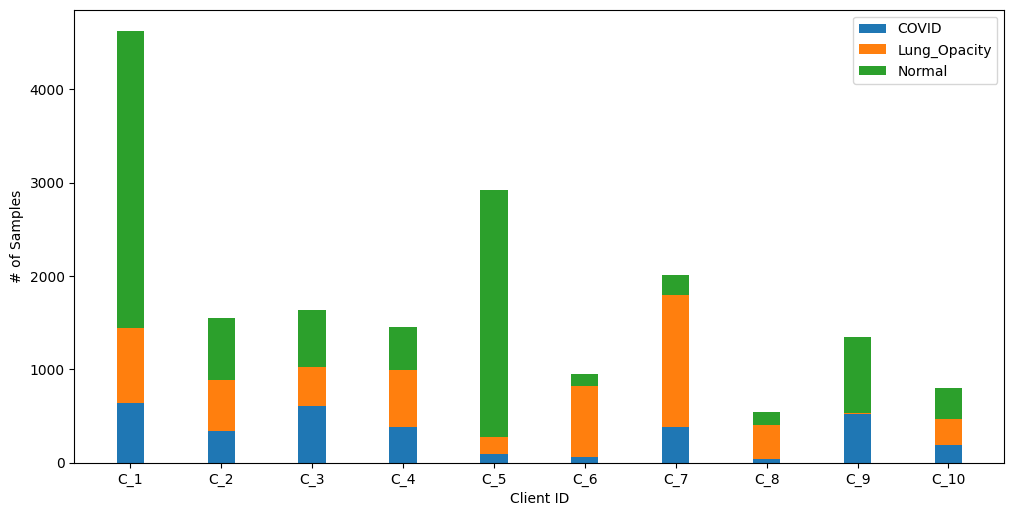

In [ ]:
fl_simulator.plotDataDistribution()

In [ ]:
central_server = server(test_set, fl_simulator.clients, args)

In [ ]:
central_server.test()


Test set: Average loss: 1.4155, Accuracy: 616/1982 (31.08%)



(1.415475229502446, 31.079717457114025)

In [ ]:
central_server.federated_train(5)

communication round: 0
LOCAL_EPOCH: 0  Client: VW_8 	Loss: 0.740562 Accuracy: 3960/5388 (73.497%)
LOCAL_EPOCH: 1  Client: VW_8 	Loss: 0.507677 Accuracy: 4419/5388 (82.016%)
LOCAL_EPOCH: 2  Client: VW_8 	Loss: 0.405389 Accuracy: 4590/5388 (85.189%)
LOCAL_EPOCH: 3  Client: VW_8 	Loss: 0.329435 Accuracy: 4762/5388 (88.382%)
LOCAL_EPOCH: 4  Client: VW_8 	Loss: 0.268358 Accuracy: 4903/5388 (90.999%)
LOCAL_EPOCH: 5  Client: VW_8 	Loss: 0.223683 Accuracy: 4989/5388 (92.595%)
LOCAL_EPOCH: 6  Client: VW_8 	Loss: 0.186443 Accuracy: 5080/5388 (94.284%)
LOCAL_EPOCH: 7  Client: VW_8 	Loss: 0.156906 Accuracy: 5130/5388 (95.212%)
LOCAL_EPOCH: 8  Client: VW_8 	Loss: 0.134349 Accuracy: 5172/5388 (95.991%)
LOCAL_EPOCH: 9  Client: VW_8 	Loss: 0.112929 Accuracy: 5201/5388 (96.529%)
LOCAL_EPOCH: 0  Client: VW_0 	Loss: 0.719456 Accuracy: 3994/5388 (74.128%)
LOCAL_EPOCH: 1  Client: VW_0 	Loss: 0.533437 Accuracy: 4286/5388 (79.547%)
LOCAL_EPOCH: 2  Client: VW_0 	Loss: 0.448382 Accuracy: 4504/5388 (83.593%)
LO

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Test set: Average loss: 0.6268, Accuracy: 1502/1982 (75.78%)

communication round: 1
LOCAL_EPOCH: 0  Client: VW_9 	Loss: 0.409203 Accuracy: 4571/5388 (84.837%)
LOCAL_EPOCH: 1  Client: VW_9 	Loss: 0.314059 Accuracy: 4766/5388 (88.456%)
LOCAL_EPOCH: 2  Client: VW_9 	Loss: 0.260149 Accuracy: 4907/5388 (91.073%)
LOCAL_EPOCH: 3  Client: VW_9 	Loss: 0.217746 Accuracy: 4987/5388 (92.558%)
LOCAL_EPOCH: 4  Client: VW_9 	Loss: 0.188218 Accuracy: 5060/5388 (93.912%)
LOCAL_EPOCH: 5  Client: VW_9 	Loss: 0.155761 Accuracy: 5118/5388 (94.989%)
LOCAL_EPOCH: 6  Client: VW_9 	Loss: 0.135454 Accuracy: 5161/5388 (95.787%)
LOCAL_EPOCH: 7  Client: VW_9 	Loss: 0.114845 Accuracy: 5212/5388 (96.733%)
LOCAL_EPOCH: 8  Client: VW_9 	Loss: 0.099588 Accuracy: 5229/5388 (97.049%)
LOCAL_EPOCH: 9  Client: VW_9 	Loss: 0.085620 Accuracy: 5242/5388 (97.290%)
LOCAL_EPOCH: 0  Client: VW_3 	Loss: 0.483242 Accuracy: 4441/5388 (82.424%)
LOCAL_EPOCH: 1  Client: VW_3 	Loss: 0.384860 Accuracy: 4641/5388 (86.136%)
LOCAL_EPOCH: 2

([75.78203834510596,
  82.34106962663975,
  84.76286579212916,
  85.67103935418768,
  86.12512613521696],
 [[...], [...], [...], [...], [...]])

In [ ]:
central_server.test()


Test set: Average loss: 0.4912, Accuracy: 1707/1982 (86.13%)



(0.4912257627878642, 86.12512613521696)

In [ ]:
central_server.federated_train(20)

communication round: 0
LOCAL_EPOCH: 0  Client: VW_3 	Loss: 0.900882 Accuracy: 3317/5309 (62.479%)
LOCAL_EPOCH: 1  Client: VW_3 	Loss: 0.660893 Accuracy: 3881/5309 (73.102%)
LOCAL_EPOCH: 2  Client: VW_3 	Loss: 0.537665 Accuracy: 4204/5309 (79.186%)
LOCAL_EPOCH: 3  Client: VW_3 	Loss: 0.438710 Accuracy: 4455/5309 (83.914%)
LOCAL_EPOCH: 4  Client: VW_3 	Loss: 0.355689 Accuracy: 4683/5309 (88.209%)
LOCAL_EPOCH: 5  Client: VW_3 	Loss: 0.290673 Accuracy: 4803/5309 (90.469%)
LOCAL_EPOCH: 6  Client: VW_3 	Loss: 0.241294 Accuracy: 4908/5309 (92.447%)
LOCAL_EPOCH: 7  Client: VW_3 	Loss: 0.204658 Accuracy: 4978/5309 (93.765%)
LOCAL_EPOCH: 8  Client: VW_3 	Loss: 0.166859 Accuracy: 5044/5309 (95.008%)
LOCAL_EPOCH: 9  Client: VW_3 	Loss: 0.139491 Accuracy: 5104/5309 (96.139%)
LOCAL_EPOCH: 0  Client: VW_7 	Loss: 0.807879 Accuracy: 3643/5309 (68.619%)
LOCAL_EPOCH: 1  Client: VW_7 	Loss: 0.538326 Accuracy: 4227/5309 (79.620%)
LOCAL_EPOCH: 2  Client: VW_7 	Loss: 0.424504 Accuracy: 4502/5309 (84.799%)
LO

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Test set: Average loss: 0.6494, Accuracy: 1536/1982 (77.50%)

communication round: 1
LOCAL_EPOCH: 0  Client: VW_2 	Loss: 0.456497 Accuracy: 4363/5309 (82.181%)
LOCAL_EPOCH: 1  Client: VW_2 	Loss: 0.334503 Accuracy: 4660/5309 (87.775%)
LOCAL_EPOCH: 2  Client: VW_2 	Loss: 0.271002 Accuracy: 4778/5309 (89.998%)
LOCAL_EPOCH: 3  Client: VW_2 	Loss: 0.222730 Accuracy: 4910/5309 (92.484%)
LOCAL_EPOCH: 4  Client: VW_2 	Loss: 0.183323 Accuracy: 4994/5309 (94.067%)
LOCAL_EPOCH: 5  Client: VW_2 	Loss: 0.149501 Accuracy: 5062/5309 (95.348%)
LOCAL_EPOCH: 6  Client: VW_2 	Loss: 0.129816 Accuracy: 5100/5309 (96.063%)
LOCAL_EPOCH: 7  Client: VW_2 	Loss: 0.107285 Accuracy: 5149/5309 (96.986%)
LOCAL_EPOCH: 8  Client: VW_2 	Loss: 0.093202 Accuracy: 5179/5309 (97.551%)
LOCAL_EPOCH: 9  Client: VW_2 	Loss: 0.076409 Accuracy: 5203/5309 (98.003%)
LOCAL_EPOCH: 0  Client: VW_7 	Loss: 0.377758 Accuracy: 4541/5309 (85.534%)
LOCAL_EPOCH: 1  Client: VW_7 	Loss: 0.285977 Accuracy: 4771/5309 (89.866%)
LOCAL_EPOCH: 2

([77.49747729566094,
  81.98789101917255,
  83.85469223007064,
  84.61150353178607,
  85.06559031281533,
  85.92330978809284,
  86.226034308779,
  87.43693239152371,
  86.27648839556004,
  87.5882946518668,
  87.38647830474268,
  88.19374369323916,
  87.84056508577194,
  88.04238143289606,
  88.0928355196771,
  88.04238143289606,
  88.34510595358223,
  88.29465186680122,
  88.79919273461151,
  88.54692230070636],
 [[...],
  [...],
  [...],
  [...],
  [...],
  [...],
  [...],
  [...],
  [...],
  [...],
  [...],
  [...],
  [...],
  [...],
  [...],
  [...],
  [...],
  [...],
  [...],
  [...]])

In [ ]:
central_server.test()


Test set: Average loss: 0.7067, Accuracy: 1755/1982 (88.55%)



(0.7067212955920958, 88.54692230070636)

In [ ]:
central_server.federated_train(50)

communication round: 0
LOCAL_EPOCH: 0  Client: VW_5 	Loss: 0.927742 Accuracy: 3016/4743 (63.588%)
LOCAL_EPOCH: 1  Client: VW_5 	Loss: 0.682531 Accuracy: 3420/4743 (72.106%)
LOCAL_EPOCH: 2  Client: VW_5 	Loss: 0.575271 Accuracy: 3692/4743 (77.841%)
LOCAL_EPOCH: 3  Client: VW_5 	Loss: 0.493082 Accuracy: 3876/4743 (81.720%)
LOCAL_EPOCH: 4  Client: VW_5 	Loss: 0.418747 Accuracy: 4036/4743 (85.094%)
LOCAL_EPOCH: 5  Client: VW_5 	Loss: 0.355304 Accuracy: 4163/4743 (87.771%)
LOCAL_EPOCH: 6  Client: VW_5 	Loss: 0.302047 Accuracy: 4270/4743 (90.027%)
LOCAL_EPOCH: 7  Client: VW_5 	Loss: 0.257626 Accuracy: 4349/4743 (91.693%)
LOCAL_EPOCH: 8  Client: VW_5 	Loss: 0.219383 Accuracy: 4418/4743 (93.148%)
LOCAL_EPOCH: 9  Client: VW_5 	Loss: 0.187074 Accuracy: 4489/4743 (94.645%)
LOCAL_EPOCH: 0  Client: VW_3 	Loss: 0.893493 Accuracy: 3064/4743 (64.600%)
LOCAL_EPOCH: 1  Client: VW_3 	Loss: 0.622137 Accuracy: 3543/4743 (74.700%)
LOCAL_EPOCH: 2  Client: VW_3 	Loss: 0.511789 Accuracy: 3801/4743 (80.139%)
LO

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Streaming output truncated to the last 5000 lines.
LOCAL_EPOCH: 5  Client: VW_6 	Loss: 0.198060 Accuracy: 4441/4743 (93.633%)
LOCAL_EPOCH: 6  Client: VW_6 	Loss: 0.164608 Accuracy: 4505/4743 (94.982%)
LOCAL_EPOCH: 7  Client: VW_6 	Loss: 0.143495 Accuracy: 4544/4743 (95.804%)
LOCAL_EPOCH: 8  Client: VW_6 	Loss: 0.117511 Accuracy: 4596/4743 (96.901%)
LOCAL_EPOCH: 9  Client: VW_6 	Loss: 0.100364 Accuracy: 4611/4743 (97.217%)

Test set: Average loss: 0.5050, Accuracy: 1646/1982 (83.05%)

communication round: 2
LOCAL_EPOCH: 0  Client: VW_6 	Loss: 0.416741 Accuracy: 4021/4743 (84.778%)
LOCAL_EPOCH: 1  Client: VW_6 	Loss: 0.318495 Accuracy: 4162/4743 (87.750%)
LOCAL_EPOCH: 2  Client: VW_6 	Loss: 0.253015 Accuracy: 4312/4743 (90.913%)
LOCAL_EPOCH: 3  Client: VW_6 	Loss: 0.216219 Accuracy: 4385/4743 (92.452%)
LOCAL_EPOCH: 4  Client: VW_6 	Loss: 0.177017 Accuracy: 4452/4743 (93.865%)
LOCAL_EPOCH: 5  Client: VW_6 	Loss: 0.151024 Accuracy: 4526/4743 (95.425%)
LOCAL_EPOCH: 6  Client: VW_6 	Loss: 0.

([79.313824419778,
  83.04742684157416,
  85.01513622603431,
  85.92330978809284,
  86.42785065590313,
  87.08375378405651,
  87.941473259334,
  88.29465186680122,
  88.29465186680122,
  88.54692230070636,
  88.64783047426842,
  88.4460141271443,
  89.40464177598385,
  89.20282542885974,
  89.50554994954591,
  89.90918264379415,
  89.80827447023209,
  89.656912209889,
  89.85872855701312,
  89.656912209889,
  89.90918264379415,
  89.95963673057517,
  90.06054490413723,
  90.0100908173562,
  90.31281533804238,
  90.0100908173562,
  89.95963673057517,
  90.26236125126135,
  90.41372351160445,
  89.90918264379415,
  90.21190716448032,
  90.16145307769929,
  90.21190716448032,
  90.51463168516649,
  90.26236125126135,
  90.26236125126135,
  90.46417759838548,
  90.61553985872855,
  90.76690211907164,
  90.36326942482341,
  90.56508577194752,
  90.71644803229061,
  90.8678102926337,
  90.66599394550958,
  91.0191725529768,
  90.91826437941474,
  90.66599394550958,
  91.0191725529768,
  90.9

In [ ]:
central_server.test()


Test set: Average loss: 0.5740, Accuracy: 1804/1982 (91.02%)



(0.5740487368932473, 91.0191725529768)

In [ ]:
central_server.federated_train(70)

communication round: 0
LOCAL_EPOCH: 0  Client: VW_8 	Loss: 0.665957 Accuracy: 3949/5234 (75.449%)
LOCAL_EPOCH: 1  Client: VW_8 	Loss: 0.405317 Accuracy: 4447/5234 (84.964%)
LOCAL_EPOCH: 2  Client: VW_8 	Loss: 0.308568 Accuracy: 4627/5234 (88.403%)
LOCAL_EPOCH: 3  Client: VW_8 	Loss: 0.242332 Accuracy: 4779/5234 (91.307%)
LOCAL_EPOCH: 4  Client: VW_8 	Loss: 0.193145 Accuracy: 4903/5234 (93.676%)
LOCAL_EPOCH: 5  Client: VW_8 	Loss: 0.157206 Accuracy: 4962/5234 (94.803%)
LOCAL_EPOCH: 6  Client: VW_8 	Loss: 0.127866 Accuracy: 5016/5234 (95.835%)
LOCAL_EPOCH: 7  Client: VW_8 	Loss: 0.104838 Accuracy: 5069/5234 (96.848%)
LOCAL_EPOCH: 8  Client: VW_8 	Loss: 0.086774 Accuracy: 5096/5234 (97.363%)
LOCAL_EPOCH: 9  Client: VW_8 	Loss: 0.068925 Accuracy: 5138/5234 (98.166%)
LOCAL_EPOCH: 0  Client: VW_7 	Loss: 0.760343 Accuracy: 3753/5234 (71.704%)
LOCAL_EPOCH: 1  Client: VW_7 	Loss: 0.534253 Accuracy: 4172/5234 (79.710%)
LOCAL_EPOCH: 2  Client: VW_7 	Loss: 0.418026 Accuracy: 4452/5234 (85.059%)
LO

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Streaming output truncated to the last 5000 lines.
LOCAL_EPOCH: 5  Client: VW_5 	Loss: 0.021440 Accuracy: 5206/5234 (99.465%)
LOCAL_EPOCH: 6  Client: VW_5 	Loss: 0.020993 Accuracy: 5195/5234 (99.255%)
LOCAL_EPOCH: 7  Client: VW_5 	Loss: 0.016758 Accuracy: 5201/5234 (99.370%)
LOCAL_EPOCH: 8  Client: VW_5 	Loss: 0.016154 Accuracy: 5206/5234 (99.465%)
LOCAL_EPOCH: 9  Client: VW_5 	Loss: 0.008452 Accuracy: 5220/5234 (99.733%)

Test set: Average loss: 0.4443, Accuracy: 1794/1982 (90.51%)

communication round: 22
LOCAL_EPOCH: 0  Client: VW_7 	Loss: 0.170529 Accuracy: 4976/5234 (95.071%)
LOCAL_EPOCH: 1  Client: VW_7 	Loss: 0.102382 Accuracy: 5056/5234 (96.599%)
LOCAL_EPOCH: 2  Client: VW_7 	Loss: 0.076077 Accuracy: 5093/5234 (97.306%)
LOCAL_EPOCH: 3  Client: VW_7 	Loss: 0.046830 Accuracy: 5145/5234 (98.300%)
LOCAL_EPOCH: 4  Client: VW_7 	Loss: 0.034543 Accuracy: 5170/5234 (98.777%)
LOCAL_EPOCH: 5  Client: VW_7 	Loss: 0.025916 Accuracy: 5180/5234 (98.968%)
LOCAL_EPOCH: 6  Client: VW_7 	Loss: 0

([80.57517658930374,
  84.91422805247225,
  87.08375378405651,
  87.79011099899091,
  88.95055499495459,
  89.3037336024218,
  89.70736629667003,
  90.41372351160445,
  89.75782038345106,
  90.0100908173562,
  89.75782038345106,
  90.36326942482341,
  90.31281533804238,
  90.71644803229061,
  90.66599394550958,
  90.46417759838548,
  90.31281533804238,
  90.66599394550958,
  90.46417759838548,
  90.66599394550958,
  90.46417759838548,
  90.51463168516649,
  90.8678102926337,
  90.56508577194752,
  90.76690211907164,
  90.66599394550958,
  90.76690211907164,
  90.96871846619577,
  90.96871846619577,
  91.0191725529768,
  90.66599394550958,
  90.96871846619577,
  90.8678102926337,
  91.06962663975781,
  91.27144298688194,
  91.52371342078709,
  91.42280524722503,
  91.17053481331988,
  91.32189707366297,
  91.372351160444,
  91.27144298688194,
  91.27144298688194,
  91.372351160444,
  91.32189707366297,
  91.17053481331988,
  91.372351160444,
  91.17053481331988,
  91.27144298688194,
  9

In [ ]:
central_server.test()


Test set: Average loss: 0.5790, Accuracy: 1797/1982 (90.67%)



(0.579007460285087, 90.66599394550958)